In [ ]:
from src.extract_data import load_data, process_data
from src.utils import get_test_set
import pandas as pd
from src.constants import FILE_PATH
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import numpy as np 
import seaborn as sns
set_matplotlib_formats('svg')
import tensorflow as tf
import IPython
import IPython.display

from src.utils import build_time_series

In [91]:
FORECAST_SIZE = 5
WINDOW_SIZE = FORECAST_SIZE * 10
NUM_FEATURES = 1

In [92]:
df = load_data(FILE_PATH)
df = process_data(df, use_covariates=False)
#df = df.drop(['day_of_month', 'month'], axis=1)



In [93]:
df.head()

,nbr_travels,nbr_late_trains
date,,
2019-03-01,18680,1799
2019-03-02,12341,1049
2019-03-03,10839,969
2019-03-04,18502,2228
2019-03-05,18373,1767


In [94]:
n = len(df)
train_df = df[0:int(n*0.7)].astype(float)
val_df = df[int(n*0.7):int(n*0.9)].astype(float)
test_df = df[int(n*0.9):].astype(float)

In [95]:
def normalize(data):
    dic = {}
    for col in ['nbr_travels', 'nbr_late_trains']:
        data_mean = data[col].mean()
        data_std = data[col].std()
        dic[col] = [data_mean, data_std]
    return dic

dic = normalize(train_df)

In [96]:
train_df['nbr_travels'] = (train_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
train_df['nbr_late_trains'] = (train_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

val_df['nbr_travels'] = (val_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
val_df['nbr_late_trains'] = (val_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

test_df['nbr_travels'] = (test_df['nbr_travels'] - dic['nbr_travels'][0]) / dic['nbr_travels'][1]
test_df['nbr_late_trains'] = (test_df['nbr_late_trains'] - dic['nbr_late_trains'][0]) / dic['nbr_late_trains'][1]

In [97]:
#train_df = train_df.drop('nbr_late_trains', axis=1)
#val_df = val_df.drop('nbr_late_trains', axis=1)
#test_df = test_df.drop('nbr_late_trains', axis=1)


train_df.head()

,nbr_travels,nbr_late_trains
date,,
2019-03-01,1.256222,0.793774
2019-03-02,-0.239490,-0.356145
2019-03-03,-0.593893,-0.478803
2019-03-04,1.214223,1.451528
2019-03-05,1.183785,0.744711


In [98]:
train_x, train_y = build_time_series(train_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)
val_x, val_y = build_time_series(val_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)
test_x, test_y = build_time_series(test_df, window_size=WINDOW_SIZE, forecast_size=FORECAST_SIZE)


train_y = [x['nbr_travels'] for x in train_y]
val_y = [x['nbr_travels'] for x in val_y]
test_y = [x['nbr_travels'] for x in test_y]

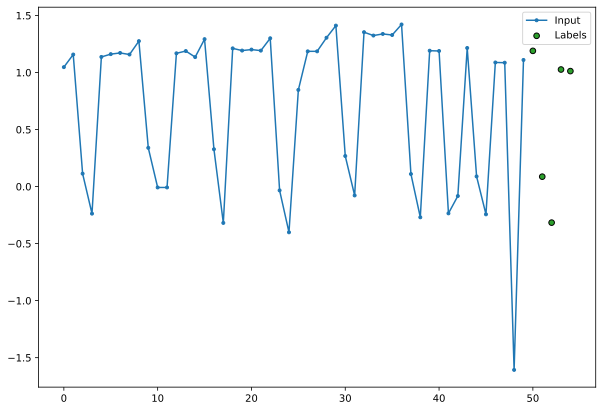

In [99]:
plot_test(test_x[0], test_y[0])

In [136]:
from datetime import timedelta
class Baseline:
    def __init__(self):
        pass
    
    def __call__(self, test_x):
        
        if type(test_x) == list:
            preds = []
            for sample in test_x:
                data = sample.copy()
                data['day'] = data.index
                last_day = data['day'].iloc[-1]
                data['day'] = data.day.apply(lambda x: x.strftime("%A"))

                first_forecast_day = last_day + timedelta(days=1)
                date_range = pd.date_range(start=first_forecast_day, periods=FORECAST_SIZE)
                date_range = [x.strftime("%A") for x in date_range]
                pred = pd.DataFrame(date_range, columns=['days'])


                pred = pred.merge(data.groupby('day').mean(), how='left', left_on='days', right_index=True)['nbr_travels'].values
                preds.append(pred)
            return preds
        else:
            data = test_x.copy()
            data['day'] = data.index
            last_day = data['day'].iloc[-1]
            data['day'] = data.day.apply(lambda x: x.strftime("%A"))

            first_forecast_day = last_day + timedelta(days=1)
            date_range = pd.date_range(start=first_forecast_day, periods=FORECAST_SIZE)
            date_range = [x.strftime("%A") for x in date_range]
            pred = pd.DataFrame(date_range, columns=['days'])


            pred = pred.merge(data.groupby('day').mean(), how='left', left_on='days', right_index=True)['nbr_travels'].values
            return np.array(pred).reshape((FORECAST_SIZE, 1))
        

In [137]:
#IPython.display.clear_output()

In [146]:
def plot_test(x_test, y_test, model = None):
    x_test_plot = x_test.values
    y_test = y_test.values
    
    y_test = y_test.reshape(y_test.shape[0], -1)
    fix, ax = plt.subplots(y_test.shape[1] , 1, figsize=(10,7))
    
    if y_test.shape[1] == 1:
        historical_index = [x for x in range(x_test.shape[0])]
        pred_index = [x+x_test.shape[0] for x in range(y_test.shape[0])]

        ax.plot(historical_index, x_test_plot[:, 0], marker='.', label='Input')
        ax.scatter(pred_index, y_test[:, 0], edgecolors='k', label='Labels', c='#2ca02c', s=32)

        if model is not None:
            preds = model(x_test)
            ax.scatter(pred_index, preds[:, 0],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            
    else:
        for i in range(y_test.shape[1]):
            historical_index = [x for x in range(x_test.shape[0])]
            pred_index = [x+x_test.shape[0] for x in range(y_test.shape[0])]

            ax[i].plot(historical_index, x_test[:, i], marker='.', label='Input')
            ax[i].scatter(pred_index, y_test[:, i], edgecolors='k', label='Labels', c='#2ca02c', s=32)

            if model is not None:
                preds = model(np.expand_dims(x_test, axis=0))[0]
                ax[i].scatter(pred_index, preds[:, i],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
    
    plt.legend()

MAPE : 62.78509 %


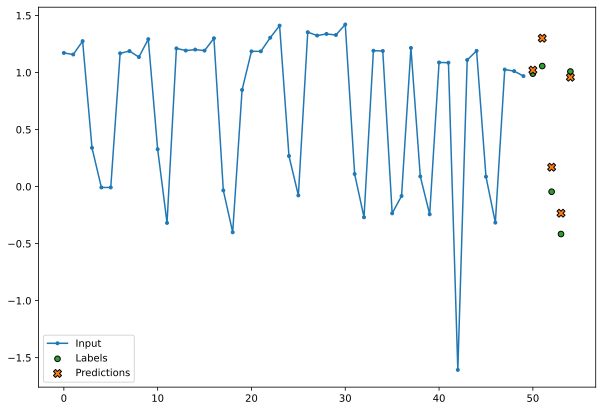

In [152]:
baseline = Baseline()
plot_test(test_x[6], test_y[6], model=baseline)
preds = baseline(test_x)

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(test_y, preds)
print('MAPE :',m.result().numpy(),'%')

In [149]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

preds = model(test_x)

mape = mean_absolute_percentage_error(np.array(preds).reshape(37,5), test_y)
mse = mean_squared_error(np.array(preds).reshape(37,5), test_y)
mae = mean_absolute_error(preds).reshape(37,5), test_y)

print('MAPE :', round(mape *100,2) ,'%')
print('MSE :', round(mse,2))
print('MAE :', round(mae,2))

MAPE : 86.12 %
MSE : 0.12
MAE : 0.23


In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
CONV_WIDTH = 5
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(FORECAST_SIZE*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([FORECAST_SIZE, NUM_FEATURES])
])

history = compile_and_fit(
    multi_conv_model,
    500,
    train_x,
    train_y,
    val_x,
    val_y)

In [ ]:
plot_test(test_x[0], test_y[0], model=multi_conv_model)
preds = multi_conv_model(test_x)

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(test_y, preds)
print('MAPE :',m.result().numpy(),'%')

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()